# Introduction | Generating elements of clothes by prompts (Conditional GAN)

> ## Importing libraries, funcs & data


In [8]:
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

### Checking the availability of CUDA

In [9]:
device_count = torch.cuda.device_count()
for i in range(device_count):
    print(torch.cuda.get_device_properties(i))

_CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16269MB, multi_processor_count=56)


## Importing Dataset & Data transformation


In [10]:
class FashionMNIST(Dataset):
    def __init__(self, train=True, transform=False):
        self.transform = None
        if transform: 
            self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))  
        ])
        self.path: str = r'/ml_notebooks/'
        
        self.data = datasets.FashionMNIST(
            root=self.path,
            train=train,
            download=True,
            transform= self.transform  
        )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]  
        return img, label

In [11]:
train_data = FashionMNIST(train=True, transform=False)
len(train_data)

100%|██████████| 26421880/26421880 [00:02<00:00, 11717699.52it/s]


Extracting /ml_notebooks/FashionMNIST/raw/train-images-idx3-ubyte.gz to /ml_notebooks/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 209928.93it/s]


Extracting /ml_notebooks/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /ml_notebooks/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:02<00:00, 1554825.17it/s]


Extracting /ml_notebooks/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /ml_notebooks/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 11193508.03it/s]

Extracting /ml_notebooks/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /ml_notebooks/FashionMNIST/raw



60000

In [12]:
train_data[0][0]

In [13]:
test_data = FashionMNIST(train=False, transform=False)
len(test_data)

10000

In [14]:
test_data[0][0]

## Discriminator Network

In [15]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(10,10)
        self.model = nn.Sequential(
            nn.Linear(794,1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        ) 
    def forward(self, x, labels):
        x = x.view(x.size(0), 784) # 28*28 
        c = self.label_emb(labels)
        x = torch.cat([x,c], 1)
        out = self.model(x)
        return out.squeeze()
        

## Generator network

In [16]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(10, 10) 
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, z, labels):
        z = z.view(z.size(0), 100)  
        c = self.label_emb(labels)  
        x = torch.cat([z, c], 1)  
        out = self.model(x)  
        return out.view(x.size(0), 28, 28)


In [17]:
gen = Generator().cuda()
disc = Discriminator().cuda()

In [18]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(disc.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(gen.parameters(), lr=1e-4)

## Training proccess 

In [19]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda())
    g_loss.backward()
    g_optimizer.step()
    return g_loss.item()

In [20]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).cuda())
    
    # train with fake images
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).cuda())
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()

Starting epoch 0...
g_loss: 3.9461538791656494, d_loss: 0.15121760964393616


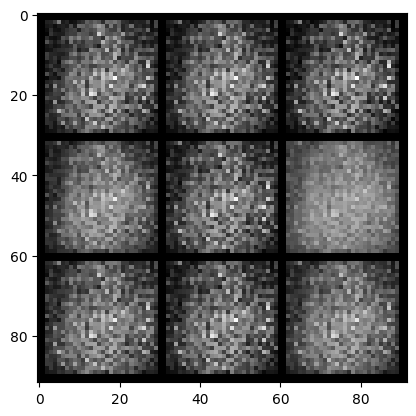

Starting epoch 1...
g_loss: 5.979876518249512, d_loss: 0.03861168026924133


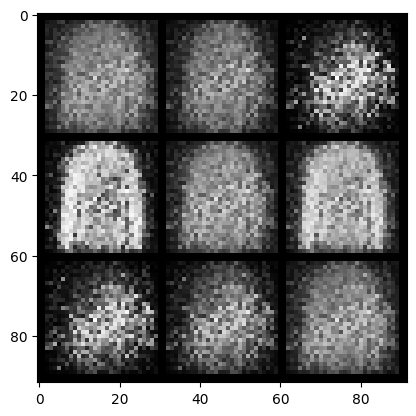

Starting epoch 2...
g_loss: 3.5992770195007324, d_loss: 0.31540271639823914


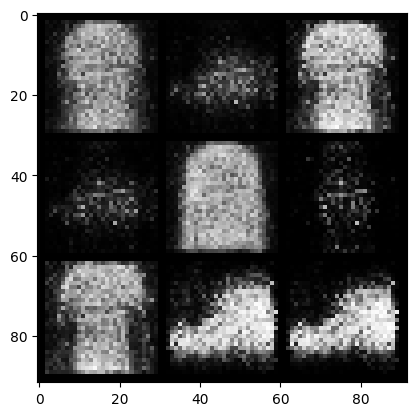

Starting epoch 3...
g_loss: 3.037515163421631, d_loss: 0.7011058330535889


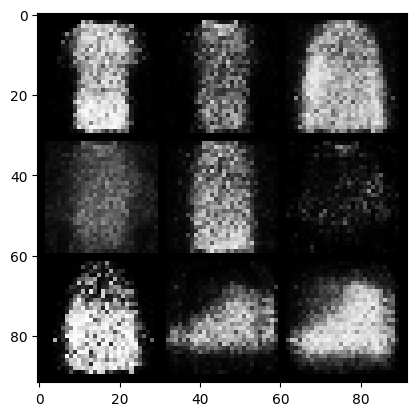

Starting epoch 4...
g_loss: 3.0125536918640137, d_loss: 0.28687381744384766


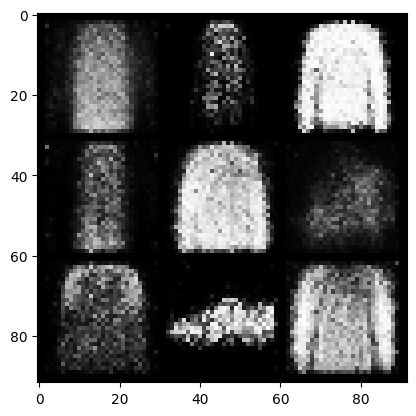

Starting epoch 5...
g_loss: 1.7630515098571777, d_loss: 0.720050036907196


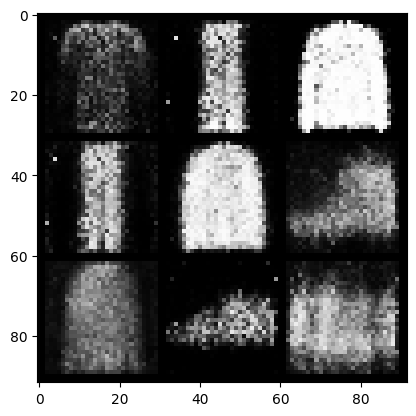

Starting epoch 6...
g_loss: 2.663567543029785, d_loss: 0.8379498720169067


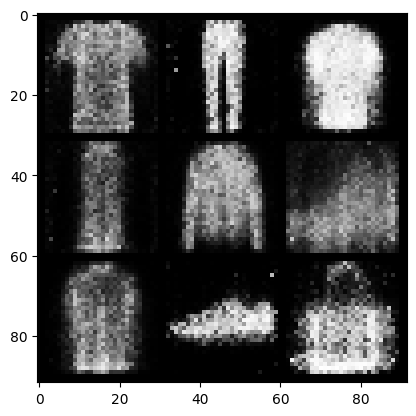

Starting epoch 7...
g_loss: 2.2794299125671387, d_loss: 0.7291611433029175


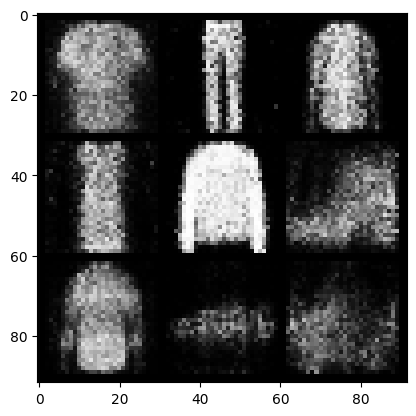

Starting epoch 8...
g_loss: 2.2266218662261963, d_loss: 0.5308198928833008


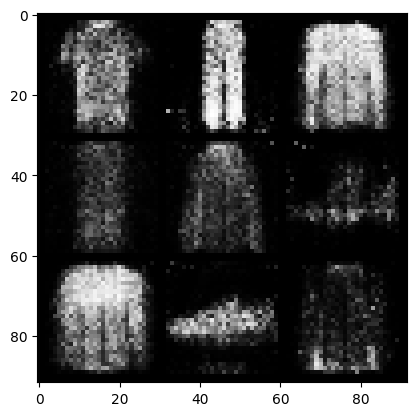

Starting epoch 9...
g_loss: 1.939076542854309, d_loss: 0.5171688199043274


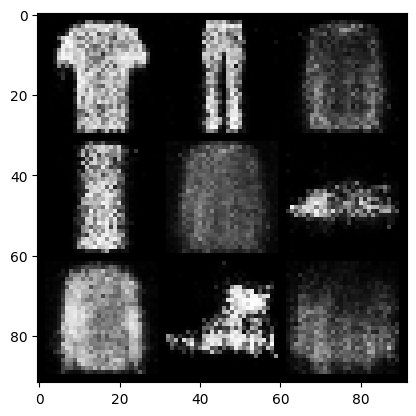

Starting epoch 10...
g_loss: 2.0843372344970703, d_loss: 0.5376702547073364


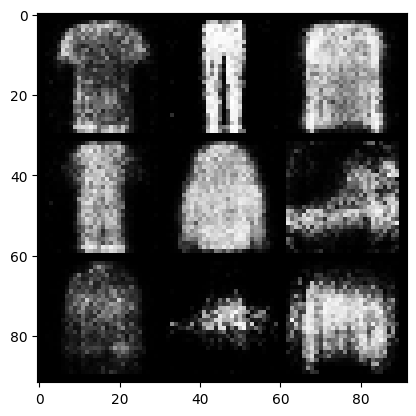

Starting epoch 11...
g_loss: 2.1799721717834473, d_loss: 0.7293575406074524


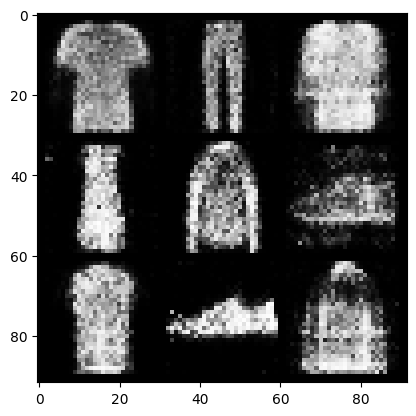

Starting epoch 12...
g_loss: 1.8229897022247314, d_loss: 0.49428871273994446


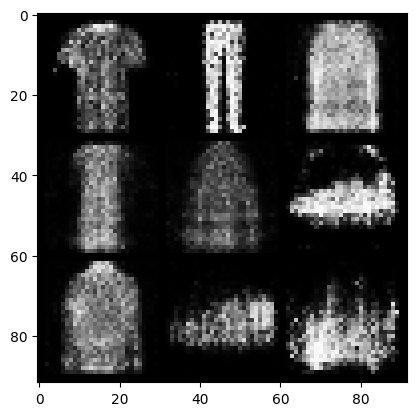

Starting epoch 13...
g_loss: 1.334995150566101, d_loss: 0.8474836349487305


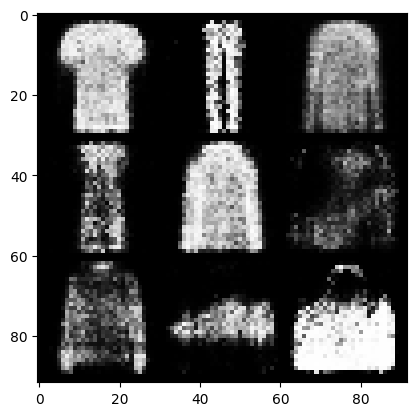

Starting epoch 14...
g_loss: 1.7735726833343506, d_loss: 0.8450988531112671


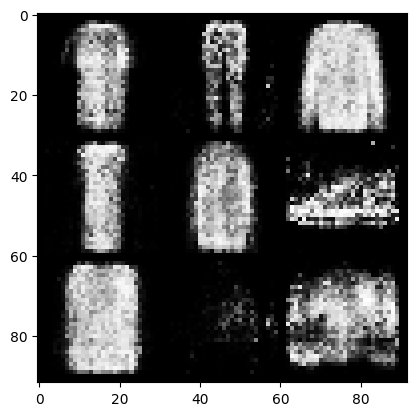

Starting epoch 15...
g_loss: 1.56681227684021, d_loss: 0.7793190479278564


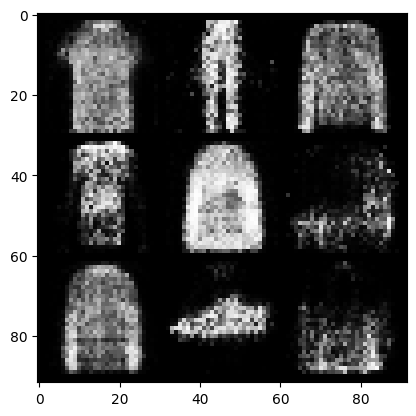

Starting epoch 16...
g_loss: 1.8396327495574951, d_loss: 1.135674238204956


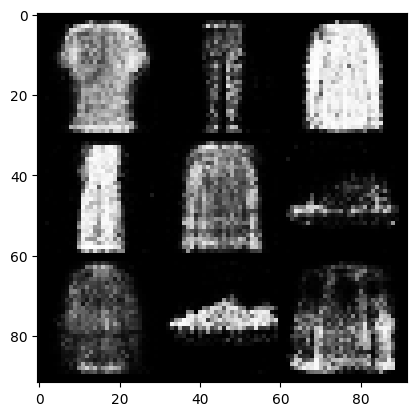

Starting epoch 17...
g_loss: 1.489396095275879, d_loss: 1.110481858253479


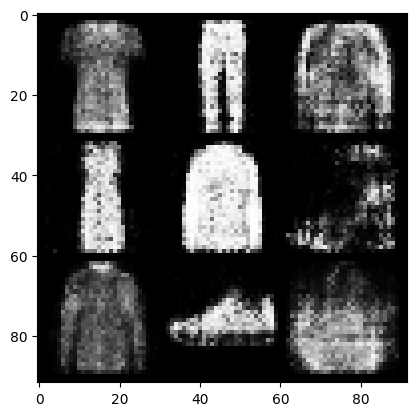

Starting epoch 18...
g_loss: 1.774519681930542, d_loss: 0.945654571056366


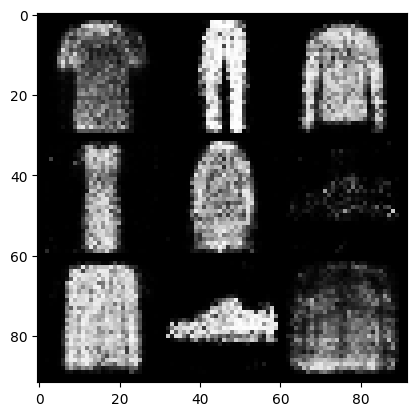

Starting epoch 19...
g_loss: 1.5286234617233276, d_loss: 0.8240737915039062


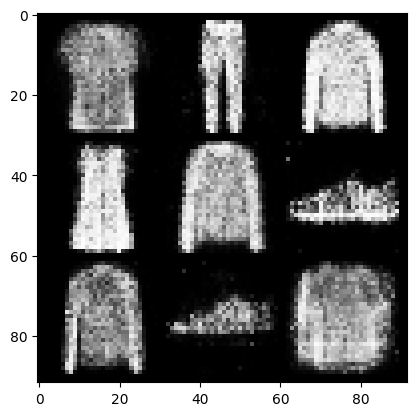

Starting epoch 20...
g_loss: 1.440786600112915, d_loss: 0.8227314352989197


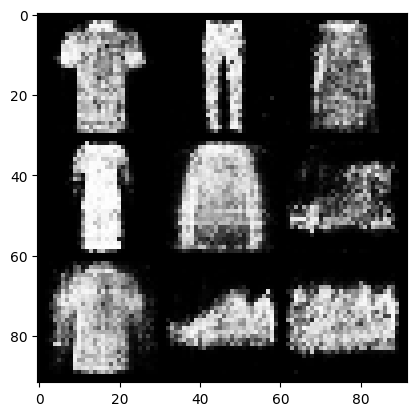

Starting epoch 21...
g_loss: 1.284538745880127, d_loss: 1.0452139377593994


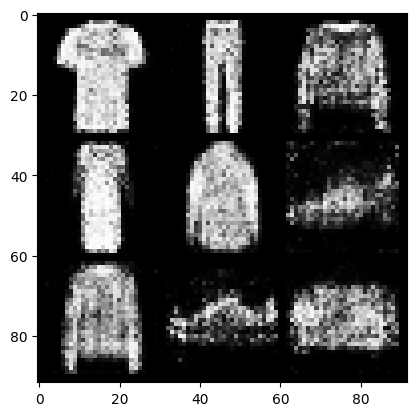

Starting epoch 22...
g_loss: 1.133516788482666, d_loss: 1.3197686672210693


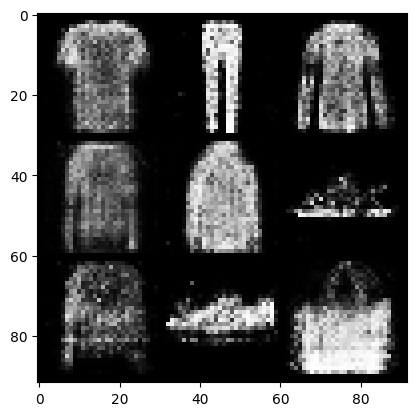

Starting epoch 23...
g_loss: 1.392735481262207, d_loss: 0.8604049682617188


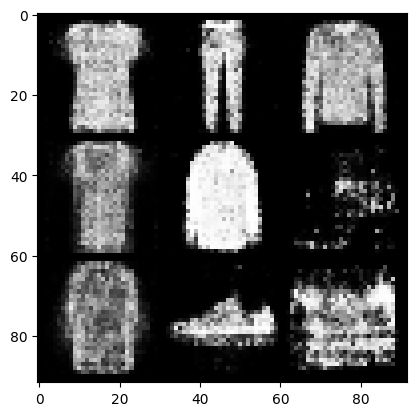

Starting epoch 24...
g_loss: 1.2169380187988281, d_loss: 1.28811776638031


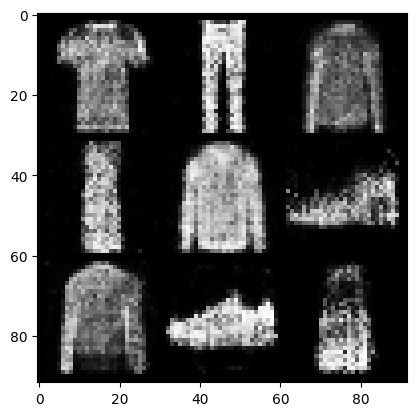

Starting epoch 25...
g_loss: 1.5413532257080078, d_loss: 1.000766634941101


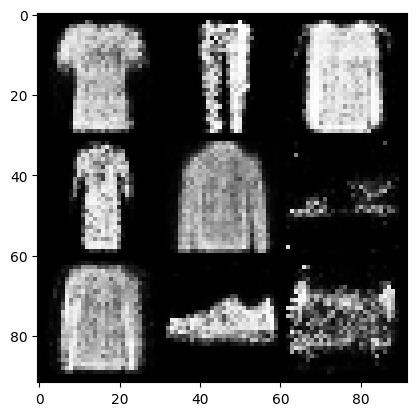

Starting epoch 26...
g_loss: 1.287187933921814, d_loss: 0.9604803919792175


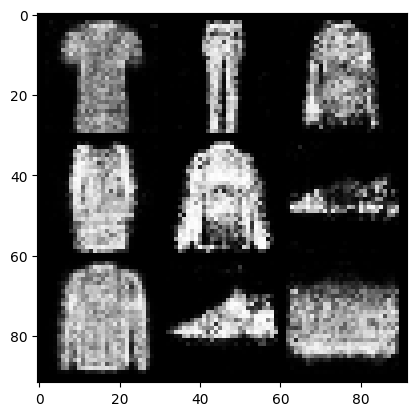

Starting epoch 27...
g_loss: 1.4422292709350586, d_loss: 0.8513858914375305


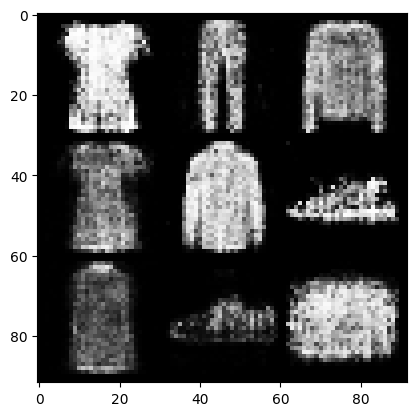

Starting epoch 28...
g_loss: 1.2079441547393799, d_loss: 0.9389708042144775


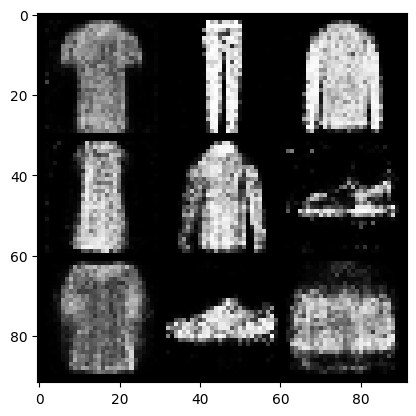

Starting epoch 29...
g_loss: 1.4360545873641968, d_loss: 0.8861108422279358


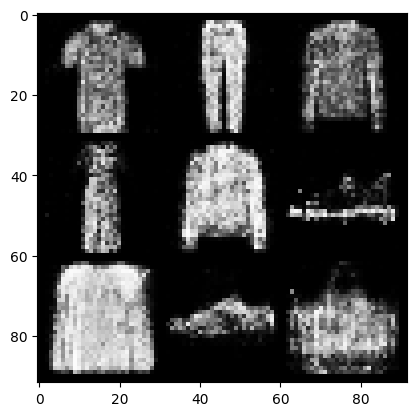

In [21]:
num_epochs = 30
n_critic = 5
display_step = 300
train_data = FashionMNIST(train=True, transform=True)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch))
    for i, (images, labels) in enumerate(train_loader):
        real_images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        gen.train()
        batch_size = real_images.size(0)
        d_loss = discriminator_train_step(len(real_images), disc,
                                          gen, d_optimizer, criterion,
                                          real_images, labels)
        

        g_loss = generator_train_step(batch_size, disc, gen, g_optimizer, criterion)

    gen.eval()
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
    z = Variable(torch.randn(9, 100)).cuda()
    labels = Variable(torch.LongTensor(np.arange(9))).cuda()
    sample_images = gen(z, labels).unsqueeze(1).data.cpu()
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()

In [25]:
torch.save(gen.state_dict(), 'generator.pth')
torch.save(disc.state_dict(), 'discriminator.pth')


In [26]:
gen = Generator() 
gen.load_state_dict(torch.load('generator.pth', weights_only=True))
gen.cuda()
gen.eval() 


Generator(
  (label_emb): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=110, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=1024, out_features=784, bias=True)
    (10): Tanh()
  )
)

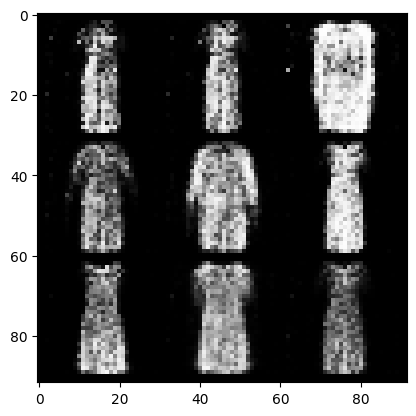

In [28]:

z = torch.randn(9, 100).cuda()

labels = torch.LongTensor([3] * 9).cuda()

sample_images = gen(z, labels).unsqueeze(1).data.cpu()  

grid = make_grid(sample_images, nrow=3, normalize=True).permute(1, 2, 0).numpy()
plt.imshow(grid, cmap="gray")
plt.show()


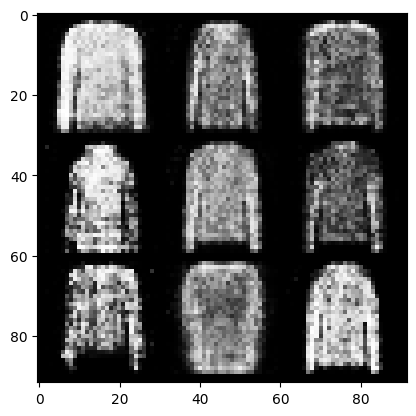

In [29]:

z = torch.randn(9, 100).cuda()

labels = torch.LongTensor([2] * 9).cuda()

sample_images = gen(z, labels).unsqueeze(1).data.cpu()  

grid = make_grid(sample_images, nrow=3, normalize=True).permute(1, 2, 0).numpy()
plt.imshow(grid, cmap="gray")
plt.show()


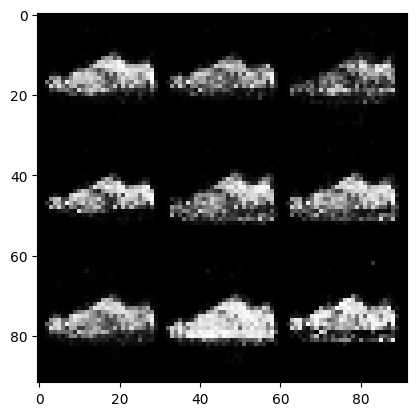

In [30]:

z = torch.randn(9, 100).cuda()

labels = torch.LongTensor([7] * 9).cuda()

sample_images = gen(z, labels).unsqueeze(1).data.cpu()  

grid = make_grid(sample_images, nrow=3, normalize=True).permute(1, 2, 0).numpy()
plt.imshow(grid, cmap="gray")
plt.show()
